# **Installing needed packages**

## Installing libraries and fetching some scripts. **It takes $\approx$ 2 minutes.**

### $\textbf{Note:}$ The Python kernel needs to be restarted for changes to be applied. This happens automatically. If you are wondering why you are seeing a message saying "*Your session crashed for an unknown reason*", this is why. You can safely ignore this message!

In [1]:
#@title Installation of packages
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()
! pip install ase chemicals pubchempy
! pip install --upgrade x3dase
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
! curl -LJO https://github.com/emartineznunez/LV_phase_diagrams/raw/main/shell_scripts/get_geom_mopac.sh
! curl -LJO https://github.com/emartineznunez/LV_phase_diagrams/raw/main/shell_scripts/get_freq_mopac.sh
! curl -LJO https://github.com/emartineznunez/LV_phase_diagrams/raw/main/shell_scripts/NM.sh
%env PATH="/content:.:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin"
%env LD_LIBRARY_PATH="/content:/usr/local/nvidia/lib:/usr/local/nvidia/lib64"
!chmod +x get_geom_mopac.sh get_freq_mopac.sh NM.sh
!conda install -c conda-forge mopac

# **Selecting the substance**

In [1]:
#@title Retrieving the CID of the substance from PubChem https://pubchem.ncbi.nlm.nih.gov/
import pubchempy as pcp
import sys

nm= 'name'
#nm = input('Identifier type: cid, name, smiles, sdf, inchi, inchikey, or formula: ')
#if nm not in ['cid','name','smiles','sdf','inchi','inchikey','formula']:
#  print('Please select one of the identifiers indicated below')
#  sys.exit()

molA = input('Name of your substance: ')

queryA0 = pcp.get_compounds(molA,nm)
if len(queryA0[0].atoms) > 1:
  queryA = pcp.get_compounds(molA,nm,record_type='3d')
else:
  queryA = pcp.get_compounds(molA,nm)

cid_A = pcp.get_cids(molA)
if len(cid_A) == 0:
  print('Molecule not found')
else:
  print('CID of molecule: ',cid_A)

Name of your substance: benzene
CID of molecule:  [241]


# **Optimization with MOPAC**

## MOPAC is a computational package that is capable of finding the mininim-energy structures of molecules using semi-empirical methods http://openmopac.net/

### Our calculations utilize PM7 semi-empirical Hamiltonian https://link.springer.com/article/10.1007/s00894-012-1667-x

### If the first optimization attempt leads to imaginary frequencies, a second attempt is made starting with a geometry $\textbf x'$ that results from a slight distortion of the original structure $\textbf x$ along the normal mode with the imaginary frequency $\textbf L_i$:

### $\textbf x'=\textbf x + \Delta x \textbf L_i$

### The final optimized structure can be visualized with X3D https://github.com/superstar54/x3dase

In [2]:
#@title Optimization, vibrational frequencies and visualization
from x3dase.visualize import view_x3d_n
from ase.io import read
import IPython

m = queryA[0]
! echo "precise denout" > molA.mop
! echo "mol A opt" >> molA.mop
! echo "mol A opt" >> molA.mop
f = open('dumpA','w')
for i,a in enumerate(m.atoms): f.write(m.elements[i]+' '+str(a.x)+' '+str(a.y)+' '+str(a.z)+'\n')
f.close()
! cat dumpA >> molA.mop
! echo "" >> molA.mop
! echo "oldgeo oldens force thermo(298,298)" >> molA.mop
!mopac molA.mop &> molA.log

#Negative freqs??
if len(m.atoms) > 1:
  freq1 = !./get_freq_mopac.sh molA.out | awk 'NR=1{print $1;exit}'
  if float(freq1[0]) < 0:
   ! echo "precise denout" > molA.mop
   ! echo "mol A opt" >> molA.mop
   ! echo "mol A opt" >> molA.mop
   !./NM.sh molA.out >> molA.mop
   ! echo "" >> molA.mop
   ! echo "oldgeo oldens force thermo(298,298)" >> molA.mop
   !mopac molA.mop &> molA.log
else:
  print('This is an atom')
#Negative freqs??

ene_A = ! awk '/FINAL HEAT OF FORMATION/{print $6}' molA.out
zpe_A = ! awk 'BEGIN{zpe=0};/ZERO POINT ENERGY/{zpe=$4};END{print zpe}' molA.out
sigmaA = ! awk '/SYMMETRY NUMBER/{print $NF}' molA.out
lin_A = ! awk 'BEGIN{l=0};/MOLECULE IS LINEAR/{l=1};END{print l}' molA.out
nat_A = len(m.atoms)

print('Energy of molecule A: %10.2f kcal/mol' % float(ene_A[0]))
print('ZPVE   of molecule A: %10.2f kcal/mol' % float(zpe_A[0]))
if float(lin_A[0]) == 1: print('Linear molecule')
print('')
print('')
print('VISUALIZATION OF THE OPTIMIZED STRUCTURE')

!./get_geom_mopac.sh molA.out > molA.xyz
atoms = read('molA.xyz')
view_x3d_n(atoms,output='molA.html', bond=1.0, label=True)
IPython.display.HTML(filename='molA.html')

Energy of molecule A:      22.96 kcal/mol
ZPVE   of molecule A:      60.21 kcal/mol


VISUALIZATION OF THE OPTIMIZED STRUCTURE


# **Plotting liquid-vapor phase-diagrams of ideal solutions**

### The vapor pressure of a pure substance $P^*(T)$ of a liquid or solid, with critical pressure and temperature $P_t$ and $T_t$, respectively, can be obtained from the Clausius equation:

### $\ln \frac{P^*}{P_t}\approx -\frac{\Delta_{tr}H_m}{R}\left(\frac{1}{T}-\frac{1}{T_t}\right)$
### $\ln \frac{P^*}{1.01325}\approx -\frac{\Delta_{tr}H_m}{R}\left(\frac{1}{T}-\frac{1}{T_b}\right)$

The difference between both equations is the reference pressure and temperature $P,T$. In the first equation, the triple point is employed, while in the seond one, the normal boiling point is selected.

The $\approx$ symbol is used because we assume that the molar volume of the gas is much greater than that of the liquid or the solid, the gas behaves ideally, and $\Delta _{tr}H_m$ remains constant along the equilibrium line. The subscript $_{tr}$ stands for transition (vaporization or sublimation).

### This pressure is compared with the empirical and more accurate Antoine's equation:

### $\log P^*=A-B/(T+C)$

In [3]:
#@title Importing libraries and defining functions
import numpy as np
import sys
from chemicals import *
# Import get function from requests module because is the function in charge of
# getting the HTTP GET request with the given url.
from requests import get
# Import BeautifulSoup from bs4 because make the html parse and help us to
# handle de DOM.
from bs4 import BeautifulSoup
# Import closing for ensure that any network resource will free when they go out
# of scope.
from contextlib import closing
import matplotlib.pyplot as plt

def p(dH,p0,T0,T):
  return p0 * np.exp(dH/R * (1/T0 - 1/T) )

#Chemical potentials Molar Gibbs energies G_m = Sum_i x_i * mu_i
def G(mu0,p,T):
  return mu0 + R * T * np.log(p / p0)

def Gm_l(T):
  return G(muA0,p(dH,PtA,TtA,T),T)

def Gm_g(T):
  return G(muA0,ptot,T)

def get_antoine_coef(Name, Temperature):

    """ Return a list with the coefficients A, B and C if they exist for the
        given Temperature. If not, return None and print it.

    :param Name:
        A string with the name of the compound in English.

    :param Temperature:
        A float number with the temperature in Kelvin.

    :rtype: List

    :return coef with [A, B, C]

    """

    # Obtaining the table using the get_html function showed below. Table is a
    # BeautifulSoup Object.
    table = get_html_table(Name)

    # Extract the rows from the table. Knowing what tags have an HTML table.
    # Also, knowing that the fist row with he table header does not have the
    # class attribute 'exp' so we obtain just the rows with data.
    # The find_all function from BeautifulSoup return a list
    rows = table.find_all('tr', class_='exp')

    # Declaring the lists for storage Temperatures, and coefficients.
    Temperatures, As, Bs, Cs = [], [], [], []

    # Looping over rows to extract and fill As, Bs, and Cs variables because now
    # we are sure the Temperatues is between some range.
    for row in rows:

        # As the rows, we extract the columns for the current row. Knowing that
        # the cols have the <td> tag in HTML as well
        # The find_all function from BeautifulSoup return a list
        cols =  row.find_all('td')

        # First transform the strings into float numbers and put them in their
        # respective list
        As.append(float(cols[1].text))
        Bs.append(float(cols[2].text))
        Cs.append(float(cols[3].text))

        # For the temperatures, we have a range and we need to extract each
        # limit (lower and higher) and put them in an extra list. So
        # Temperatures variable will be a list of lists.
        lower_lim = float(cols[0].text.replace(" ","").split('-')[0])
        higher_lim = float(cols[0].text.replace(" ","").split('-')[1])
        Temperatures.append([lower_lim, higher_lim])


    # Checking if the Temperature gave fits in some interval
    #index = None
    #for i, interval in enumerate(Temperatures):
    #    if (interval[0] <= Temperature
    #        and Temperature <= interval[1]):
    #        index = i
    #        break
    #    else:
    #        index = None

    #if index == None:
    #    print('Sorry, the data for the given temperature %.2f K does not exist in the Data Base' % Temperature)
    #    return None
    #else:
    A = As[0]
    B = Bs[0]
    C = Cs[0]
    t = Temperatures[0]
    return [t, A, B, C]

def get_html_table(Name):

    """ Return the html already parsed using the a helper function listed below.

    :param Name:
        A string with the name of the compound in English.

    :rtype: BeautifulSoup Object

    """

    # The name parameter is part of the url. For example, if you want the
    # methane data, the url is
    # https://webbook.nist.gov/cgi/cbook.cgi?Name=methane&Mask=4.
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?Name={0}&Mask=4', Name.lower())

    # Function to get the request made, see below.
    raw_html = get_response(url)

    # Parse the html using BeautifulSoup.
    html = BeautifulSoup(raw_html, 'html.parser')

    # Extract the table that contains the data, the table has a specific
    # attributes 'aria-label' as 'Antoine Equation Parameters'.
    table = html.find('table', attrs={'aria-label': 'Antoine Equation Parameters'})

    return table


def get_response(url):

    """ Return the raw_html for parsing later or None if can't reach the page

    :param url:
        The string for the GET request.

    :rtype: BeautifulSoup Object

    :rtype: None if can't reach the website

    """

    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except:
        print('Not found')
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200
            and content_type is not None
            and content_type.find('html') > -1)


Substance :  benzene
Properties:
Heat of vaporization:      30.92 kJ/mol
Heat of fusion:             9.87 kJ/mol
Heat of sublimation:       40.79 kJ/mol
Boiling point:            353.22 K
Triple  point temp:       278.67 K
Triple  point pres:         0.05 bar
Critical point T          562.02 K
Critical point P           49.07 bar



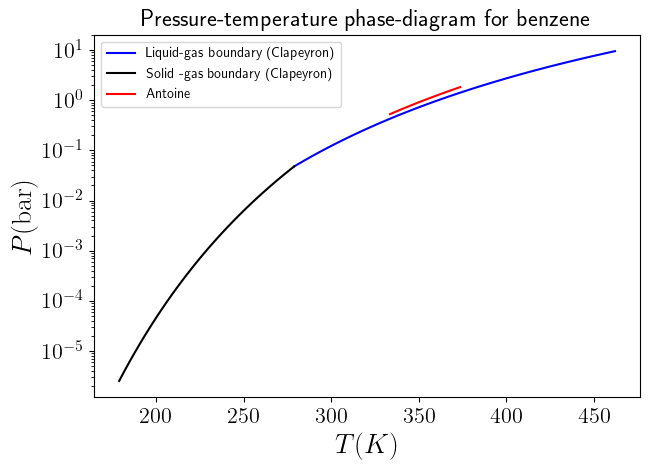

In [4]:
#@title Plotting the phase diagram
#Pressures, temperature range for the L-V phase diagram and constants
p0 = 1 # standard pressure of 1 bar
R = 8.314472e-3  # kJ/(K mol)

#Retrieve properties of molecules
moleculeA = search_chemical(molA)
TA0  = Tb(moleculeA.CASs)
TAc = Tc(moleculeA.CASs)
PcA = Pc(moleculeA.CASs)
TtA = Tt(moleculeA.CASs)
PtA = Pt(moleculeA.CASs) * 1e-5
dHA = Liu(TA0,TAc,PcA) * 1e-3
dHfA = Hfus(moleculeA.CASs) * 1e-3
PcA = PcA * 1e-5
dHsA = dHfA + dHA

print('\033[1mSubstance :\033[0m ',molA)
print('\033[1mProperties:\033[0m')
print('Heat of vaporization: %10.2f kJ/mol' % dHA)
print('Heat of fusion:       %10.2f kJ/mol' % dHfA)
print('Heat of sublimation:  %10.2f kJ/mol' % dHsA)
print('Boiling point:        %10.2f K' % TA0)
print('Triple  point temp:   %10.2f K' % TtA)
print('Triple  point pres:   %10.2f bar' % PtA)
print('Critical point T      %10.2f K' % TAc)
print('Critical point P      %10.2f bar' % PcA)
print('')

ans = get_antoine_coef(molA,TA0)
if len(ans) == 0:
  print('No Antoine parameters found in NIST')
  sys.exit()
else:
  Tlim = min(TtA+500,TAc-100)
  if Tlim < TtA: Tlim = TtA + 50
  #Plot the P-T diagram (P vs T)
  Ta = np.linspace(ans[0][0],ans[0][1],100)
  T1 = np.linspace(TtA,Tlim,100)
  T2 = np.linspace(TtA-100,TtA,100)
  plt.rcParams['text.usetex'] = True
  plt.plot(T1,p(dHA,PtA,TtA,T1),'-',color='blue',label='Liquid-gas boundary (Clapeyron)')
  plt.plot(T2,p(dHsA,PtA,TtA,T2),'-',color='black',label='Solid -gas boundary (Clapeyron)')
  plt.plot(Ta,10**(ans[1]-(ans[2]/(Ta+ans[3]))),'-',color='red',label='Antoine')
  plt.ylabel(r'$P(\mathrm{bar})$',fontsize=20)
  plt.xlabel(r'$T(K)$',fontsize=20)
  plt.legend()
  plt.title('Pressure-temperature phase-diagram for '+molA, fontsize=17)
  #plt.ylim(bottom=0.1)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.tight_layout()
  plt.savefig('P_T.svg')
  plt.yscale('log')
  plt.show()

# **Plotting Gibbs energies of the different phases for different temperatures**

# Calculation of the chemical potentials of the pure substances.

### The chemical potential of the pure gas is:
### $\mu_{gas}^*(T,P)=\mu^0(T)+RT\ln\frac{P}{P^0}$

### On the other hand, the chemical potential of the pure liquid is:
### $\mu_{liq}^*(T,P^*)=\mu^0(T)+RT\ln\frac{P^*}{P^0}$

### with $P^*$ being the vapor pressure in equilibrium with the liquid at temperature $T$, which can be obtained from the above Clapeyron equations.

### The standard-state chemical potential $\mu^0(T)$ can be easily determined from statistical mechanics:

### $\mu^0(T)=U(0)-RT\ln \frac{q_m^{0}}{N_A}$

### where $U(0)$ is the internal energy of the system at $T=0$. For a molecule, this value is the sum of the electronic, $E_{el}$, and zero-point vibrational energies, $\mathrm{ZPVE}$. These are calculated in the above MOPAC calculation.
### The second term, $-RT\ln (q_m^{0}/N_{A})$, is a thermal correction with:

### $\frac{q_m^{0}}{N_A} =\frac{q_{tr,m}^{0}}{N_A} \times q_{rot} \times q_{vib} = \left( \frac{2\pi mk_B T}{h^{2}} \right)^{3/2} \frac{k_BT}{P^{0}} \times \frac{1}{\sigma} \left( \frac{k_BT}{hc} \right)^{3/2} \left( \frac{\pi}{\tilde{A}\tilde{B}\tilde{C}}\right)\times \prod_{i=1}^{N_v}\frac{1}{1-\exp(-hc\tilde{\nu} /k_BT)}$

### The above expression utilizes the Rigid-Rotor/Harmomic Oscillator model for a polyatomic non-linear molecule. For a linear molecule, $q_{rot}$ should be replaced by $\frac{1}{\sigma} \left( \frac{k_BT}{hc\tilde{B}} \right)$

### The crossing point between the liquid and gas chemical potentials takes place when $P^*=P$, *i.e.*, for a temperature $T_{cross}$ of:

### $T_{cross}=\frac{1}{\frac{1}{T_t}-\frac{R}{\Delta_{vap}H_m}\ln\frac{P}{P_t}}$



Total pressure (in bar): 2
Crossover T =     386.90 K


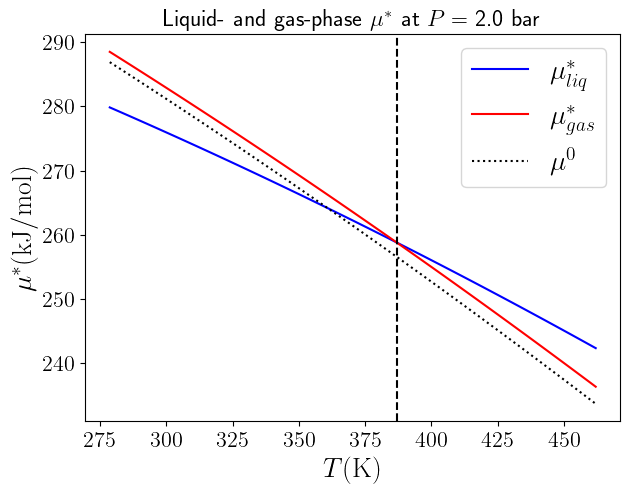

In [5]:
#@title Determining Gibbs energies
def G_m_0(temp,m,A,B,C,lin_A,nat_A,sigma,*freq):
  import math
  q_t = (2*math.pi*m*m_u*k_B*temp/h/h)**1.5*k_B*temp/bar2Pa
  if nat_A > 1:
    rA  = h * c * 100 * A / k_B
    rB  = h * c * 100 * B / k_B
    rC  = h * c * 100 * C / k_B
    if lin_A == 0:
      q_r = 1 / sigma * math.sqrt(math.pi)*(temp**1.5/math.sqrt(rA*rB*rC))
    else:
      if rA == 0:
        rl = math.sqrt(rB*rC)
      elif rB == 0:
        rl = math.sqrt(rA*rC)
      else:
        rl = math.sqrt(rA*rB)
      q_r = 1 / sigma * temp / rl
    q_v = 1
    for ele in freq:
      rv  = h * c * 100 * float(ele) / k_B
      q_v = -q_v / math.expm1(-rv/temp)
  else:
    q_r = 1
    q_v = 1
  q = q_t * q_r * q_v
  return - R * temp * np.log(q)

def pfs(temp,m,A,B,C,lin_A,nat_A,sigma,*freq):
  import math
  q_t = (2*math.pi*m*m_u*k_B*temp/h/h)**1.5*k_B*temp/bar2Pa
  if nat_A > 1:
    rA  = h * c * 100 * A / k_B
    rB  = h * c * 100 * B / k_B
    rC  = h * c * 100 * C / k_B
    if lin_A == 0:
      q_r = 1 / sigma * math.sqrt(math.pi)*(temp**1.5/math.sqrt(rA*rB*rC))
      expo = 5/2 + 3/2
    else:
      if rA == 0:
        rl = math.sqrt(rB*rC)
      elif rB == 0:
        rl = math.sqrt(rA*rC)
      else:
        rl = math.sqrt(rA*rB)
      q_r = 1 / sigma * temp / rl
      expo = 5/2 + 1
    q_v = 1
    for ele in freq:
      rv  = h * c * 100 * float(ele) / k_B
      q_v = -q_v / math.expm1(-rv/temp)
  else:
    q_r = 1
    q_v = 1
  q = q_t * q_r * q_v
  q_prime = q / temp**expo
  return q_t,q_r,q_v,q_prime

m_u = 1.66053886e-27      # atomic mass constant in kg
h = 6.6260693e-34         # J s
k_B = 1.3806505e-23       # J/K
c = 2.99792558e8          # speed of light in m/s
bar2Pa = 1e5          # 1 bar to N/m**2
N = 100
ptot = float(input("Total pressure (in bar): "))             # 0.2 bar
# For the temperature dependence of mu0 check this:
# https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Thermodynamics_and_Chemical_Equilibrium_(Ellgen)/24%3A_Indistinguishable_Molecules_-_Statistical_Thermodynamics_of_Ideal_Gases/24.10%3A_The_Gibbs_Free_Energy_for_One_Mole_of_An_Ideal_Gas

# The standard-state chemical potentials of the substances in the gas phase (determine from Statistical Thermodynamics)
muA0 = np.empty(N)
qt = np.empty(N)
qr = np.empty(N)
qv = np.empty(N)
qp = np.empty(N)
corr = np.empty(N)

! ./get_freq_mopac.sh molA.out > dum
freqA = ! awk '{if($1<0) print -$1; else print $1}' dum
mA = ! awk '/MOLECULAR WEIGHT/{print $4;exit}' molA.out
AA = ! awk '/A =/{print $3; exit}' molA.out
BA = ! awk '/A =/{print $6; exit}' molA.out
CA = ! awk '/A =/{print $9; exit}' molA.out

T100 = np.linspace(0.01,400,100)

for Ti in T100:
  index = np.where(T100 == Ti)[0][0]
  corri = G_m_0(Ti,float(mA[0]),float(AA[0]),float(BA[0]),float(CA[0]),float(lin_A[0]),nat_A,float(sigmaA[0]),*freqA)
  corr[index]=corri

T = T1
for Ti in T:
  index = np.where(T == Ti)[0][0]
  corrA = G_m_0(Ti,float(mA[0]),float(AA[0]),float(BA[0]),float(CA[0]),float(lin_A[0]),nat_A,float(sigmaA[0]),*freqA)
  qti,qri,qvi,qpi = pfs(Ti,float(mA[0]),float(AA[0]),float(BA[0]),float(CA[0]),float(lin_A[0]),nat_A,float(sigmaA[0]),*freqA)
  muA0i = (float(ene_A[0])+float(zpe_A[0]) )*4.184 + corrA
  muA0[index] = muA0i
  qt[index]=qti
  qr[index]=qri
  qv[index]=qvi
  qp[index]=qpi

dH = dHA
tcross = 1 / (1 / TtA - R /dH * np.log(ptot/PtA))
print('Crossover T =  %9.2f K' % tcross)
#Plot the Gibbs energies of the different phases
plt.rcParams['text.usetex'] = True
plt.plot(T,Gm_l(T),'-',color='blue', label='$\mu_{liq}^*$')
plt.plot(T,Gm_g(T),'-',color='red', label='$\mu_{gas}^*$')
plt.plot(T,muA0,':',color='black', label='$\mu^0$')
plt.ylabel(r'$\mu^*(\mathrm{kJ/mol})$',fontsize=20)
plt.xlabel(r'$T(\mathrm{K})$',fontsize=20)
plt.legend(fontsize=20)
#plt.xlim(cot,cot2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=tcross,color='black',ls='--')
plt.tight_layout()
plt.title('Liquid- and gas-phase $\mu^*$ at $P=$ '+str(ptot)+' bar', fontsize=17)
plt.savefig('Gibbs_energies.svg')
plt.show()


### The difference between $\mu_{liq}^*$ and $\mu_{gas}^*$ arises from the difference in the molar Gibbs energy to bring and ideal gas from pressure $P^*$ to $P$:

### $d\mu_{l-g}^*=dG_m=V_mdP'-S_mdT$

For a fixed temperature process,

### $d\mu_{l-g}^*=V_mdP'$

and,

### $\Delta \mu_{l-g}^*=\int_{P^*}^{P} V_mdP'=\int_{P^*}^{P}\frac{RT}{P'}dP'=RT\ln \frac{P}{P^*}=\Delta G_{g,m}(P^*→P)$

### The gap between the liquid and gas chemical potentials $\Delta \mu_{l-g}^*$ can be further developed using Clapeyron equation to obtain:

### $\Delta \mu_{l-g}^*=\Delta_{vap} H_m- T\times \left(\frac{\Delta_{vap}H_m}{T_b} - R\ln \frac{P}{1.01325} \right)=\Delta_{vap} H_m-T\times(\Delta_{vap} S_m+\Delta S_{g,m}(1.01325\rightarrow P))=\Delta_{vap} G_m+\Delta G_{g,m}(1.01325\rightarrow P)$

### where the first entropy change refers to the approximate value for the entropy of vaporization, and the second one is the molar entropy change of the gas when the pressure changes from $1.01325$ bar to $P$.

### On the other hand, the slope of the $\mu^0(T)$ curve is $-S$ by definition:

### $\left( \frac{\partial G_m^0}{\partial T} \right)_P=-S_m^0$

### From the thermodynamic definition of the Gibbs energy function:

### $ S_m^0=\frac{H_m^0-G_m^0}{T}=C_{p,m}^0-\frac{G_m^0}{T}$

### At constant pressure, the change in the standard molar entropy from a reference temperature, $T_{ref}$, to a temperature $T$ is:

### $S_m^0(T)-S_m^0(T_{ref})=C_{p,m}^0\ln \left(\frac{T}{T_{ref}} \right)$

### Using the equation above for $S_m^0(T_{ref})$, we get:

### $ S_m^0=C_{p,m}^0\left( 1+\ln \frac{T}{T_{ref}}\right)+ \frac{G_m^0(T_{ref})}{T_{ref}}$

### If we take $T_{ref}=1$ $\mathrm K$, the last term $\frac{G_m^0(T_{ref})}{T_{ref}}$ can be safely neglected, and an approximate results for the standard-state chemical potential can be written as:

### $\mu^0(T)=C_{p,m}^0 T\left(1-\ln \frac{T}{T_{ref}}\right)$

### Considering the equipartition theorem, the heat capacity at constant pressure:

### $C_{p,m}^0=\frac{5+\nu_{rot}+2\nu_{vib}}{2}R=\nu^*R$

### where $\nu_{rot}$ is the number or rotational degrees of freedom ($dof$s) of our molecule, and $\nu_{vib}$ accounts for the vibrational $dof$ with vibrational frequencies below $500$ $\mathrm{cm}^{-1}$.

### Therefore:

### $\mu^0(T)=\nu^*R T\left(1-\ln \frac{T}{T_{ref}}\right)$
### $\mu_{gas}(T,P)=RT\left(\nu^*+\ln\frac{PT_{ref}}{P^0T^{\nu^*}} \right)$
### $\mu_{liq}(T,P^*)=RT\left(\nu^*+\ln\frac{P^*T_{ref}}{P^0T^{\nu^*}} \right)$


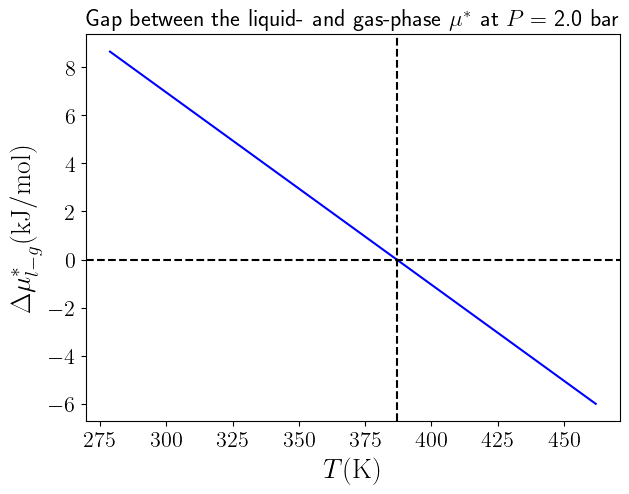

In [6]:
#@title Gap between the liquid- and the gas-phase $\mu^*$
T = T1

dnu = np.empty(N)
for Ti in T:
  index = np.where(T == Ti)[0][0]
  dnui = dHA + (R * np.log(ptot/PtA) - dHA/TtA) * Ti
  dnu[index] = dnui

#Plot the gap
plt.rcParams['text.usetex'] = True
plt.plot(T,dnu,'-',color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=tcross,color='black',ls='--')
plt.axhline(y=0,ls="--",color='black')
plt.ylabel(r'$\Delta\mu_{l-g}^*(\mathrm{kJ/mol})$',fontsize=20)
plt.xlabel(r'$T(\mathrm{K})$',fontsize=20)
plt.tight_layout()
plt.title('Gap between the liquid- and gas-phase $\mu^*$ at $P=$ '+str(ptot)+' bar', fontsize=17)
plt.savefig('Gap.svg')
plt.show()

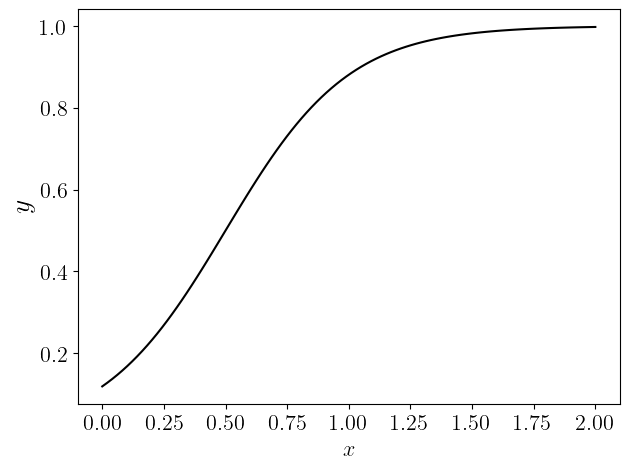

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.5
 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 3.  3.  3.  3.
 3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.5 4.5 4.5 4.5 4.5 4.5
 4.5 5.5 5.5 5.5 6.  6.  6.  6.  6.  6. ]


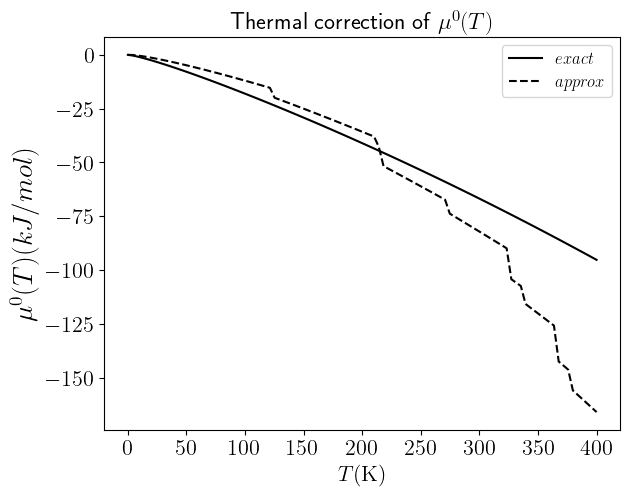

In [133]:
#@title Partition functions
#Plot the partition functions as a function of T
#plt.plot(T,np.log(qt),'-',color='blue', label='$tr$')
#plt.plot(T,np.log(qr),'-',color='red', label='$rot$')
#plt.plot(T,np.log(qv),'-',color='black', label='$vib$')
#plt.plot(T,1/4*np.log(qp),'--',color='blue', label='$1/4\ln C$')
#plt.plot(T,1+np.log(T),'--',color='red', label='$1+\ln T$')


#plt.plot(T,np.log(qv*qr*qt),'--',color='black', label='$tot$')
#plt.plot(T,-R*T*np.log(qv*qr*qt),':',color='black', label='$G_{corr}$')
#plt.ylabel(r'$\ln q$',fontsize=20)
#plt.xlabel(r'$T(\mathrm{K})$',fontsize=16)
#plt.legend(fontsize=12)
#plt.xlim(cot,cot2)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
#plt.axvline(x=tcross,color='black',ls='--')
#plt.tight_layout()
#plt.title('Breakdown of the different contributions to $q$', fontsize=17)
#plt.savefig('Partition_functions.svg')
#plt.show()

#mut1= G_m_0(1,float(mA[0]),float(AA[0]),float(BA[0]),float(CA[0]),float(lin_A[0]),nat_A,float(sigmaA[0]),*freqA)

nu_rot = 3 - int(lin_A[0])
nu_vib = np.zeros(100)

xx = np.linspace(0,2,100)
yy = (1 + np.tanh(2*(xx-0.5)))/2

plt.plot(xx,yy,'-',color='black', label='$exact$')
plt.ylabel(r'$y$',fontsize=20)
plt.xlabel(r'$x$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

for freq in freqA:
  tita = h * c * 100 * float(freq) / k_B
  index = 0
  for ele in T100:
    x = ele / tita
    #nu_vibi = max(0,min(1,1.2*x-0.2))
    #nu_vibi = (1 / x) ** 2 * ( np.exp(-(1/(2 * x))) / (1 - np.exp (-1 / x) ) ) ** 2
    if x > 0.25:
      nu_vibi = 0.5
    elif x > 0.5:
      nu_vibi = 1
    else:
      nu_vibi = 0


    #print(x,nu_vibi)
    nu_vib[index] += nu_vibi
    index += 1

print(nu_vib)

nu = (5 + nu_rot + 2 * nu_vib) / 2
#print(nu)
plt.plot(T100,corr,'-',color='black', label='$exact$')
plt.plot(T100,nu*R*T100*(1-np.log(T100)),'--',color='black', label='$approx$')
plt.ylabel(r'$\mu^0(T) (kJ/mol)$',fontsize=20)
plt.xlabel(r'$T(\mathrm{K})$',fontsize=16)
plt.legend(fontsize=12)
#plt.xlim(cot,cot2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.axvline(x=tcross,color='black',ls='--')
plt.tight_layout()
plt.title('Thermal correction of $\mu^0(T)$', fontsize=17)
plt.show()



100 143.8775609708807
200 287.7551219417614
300 431.63268291264205
400 575.5102438835228
500 719.3878048544035
600 863.2653658252841


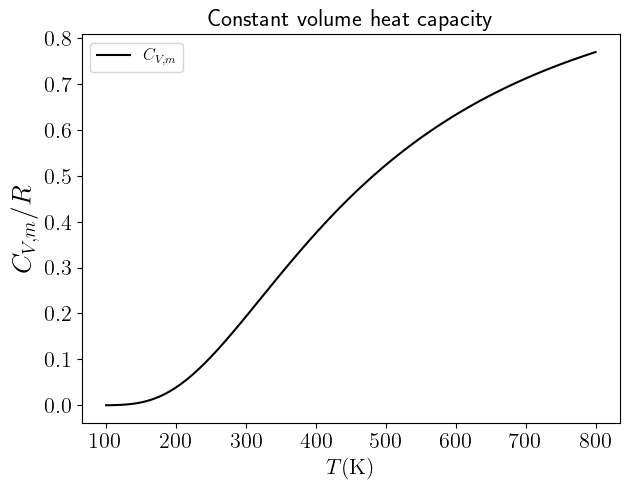

In [8]:
#@title heat capacity as a function of freqs

for freq in range(100,700,100):
  tita = h * c * 1.e2 * freq / k_B
  print(freq,tita)

freq = 1000
tita = h * c * 1.e2 * freq / k_B
temp = np.linspace(100,800,100)
c_v = (tita / temp) ** 2 * ( np.exp(-(tita/2/temp)) / (1 - np.exp (-tita / temp) ) ) ** 2

plt.plot(temp,c_v,'-',color='black', label='$C_{V,m}$')
plt.ylabel(r'$C_{V,m}/R$',fontsize=20)
plt.xlabel(r'$T(\mathrm{K})$',fontsize=16)
plt.legend(fontsize=12)
#plt.xlim(cot,cot2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.axvline(x=tcross,color='black',ls='--')
plt.tight_layout()
plt.title('Constant volume heat capacity', fontsize=17)
plt.show()